This notebook contains work-in-progress code for prediction of application usage time, and has not been integrated into the main project yet.

In [ ]:
# For importing library code
sys.path.insert(0, '../src/data')                                                                                                                                                  

import etl

In [20]:
from datetime import datetime

In [ ]:
string_df_0, ull_df_0 = get_all_databases('group3_collected_data')

In [21]:
df = string_df_0[string_df_0['ID_INPUT'] == 3]
df['MEASUREMENT_TIME'] = pd.to_datetime(df['MEASUREMENT_TIME'])
df['TIME_DIFFERENCES'] = pd.Series()
times = df['MEASUREMENT_TIME']
for i in range(len(times)-1):
    df['TIME_DIFFERENCES'].iloc[i] = (pd.Timedelta(times.iloc[i+1] - times.iloc[i], 'milliseconds'))
df

C:\Users\jared\AppData\Local\Temp/ipykernel_18884/1570987682.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MEASUREMENT_TIME'] = pd.to_datetime(df['MEASUREMENT_TIME'])
C:\Users\jared\AppData\Local\Temp/ipykernel_18884/1570987682.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['TIME_DIFFERENCES'] = pd.Series()
C:\Users\jared\AppData\Local\Temp/ipykernel_18884/1570987682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA,TIME_DIFFERENCES
1,2021-11-20 21:30:30.578,3,cmd.exe,0,0 days 00:00:05.559000
6,2021-11-20 21:30:36.137,3,explorer.exe,0,0 days 00:00:03.312000
9,2021-11-20 21:30:39.449,3,chrome.exe,0,0 days 00:00:27.710000
14,2021-11-20 21:31:07.159,3,explorer.exe,0,0 days 00:00:00.870000
15,2021-11-20 21:31:08.029,3,chrome.exe,0,0 days 00:09:39.040000
...,...,...,...,...,...
53810,2022-01-11 20:24:51.106,3,chrome.exe,0,0 days 00:00:07.382000
53811,2022-01-11 20:24:58.488,3,cmd.exe,0,0 days 00:01:12.522000
53814,2022-01-11 20:26:11.010,3,chrome.exe,0,0 days 00:00:02.828000
53815,2022-01-11 20:26:13.838,3,explorer.exe,0,2 days 00:00:04.143000


***

In [218]:
temp = string_df_0.copy()

In [219]:
# getting only foreground instances
foreground_0 = temp[temp['ID_INPUT'] == 3].reset_index(drop=True)

In [220]:
# getting time differences between applications and adding column to DataFrame
time_0 = pd.to_datetime(foreground_0.iloc[:, 0]).reset_index(drop=True)
time_1 = pd.to_datetime(foreground_0.iloc[1:, 0]).append(pd.Series(np.nan)).reset_index(drop=True)
time_delta = (time_0 - time_1).apply(lambda x: -x.total_seconds())
foreground_0 = foreground_0.assign(**{'TIME_DELTA': time_delta})

# # removing outliers: applications that in the foreground for more than 3 hours straight
foreground_0 = foreground_0[foreground_0['TIME_DELTA'] < 10800]

In [221]:
time_delta.head()

0      5.559
1      3.312
2     27.710
3      0.870
4    579.040
dtype: float64

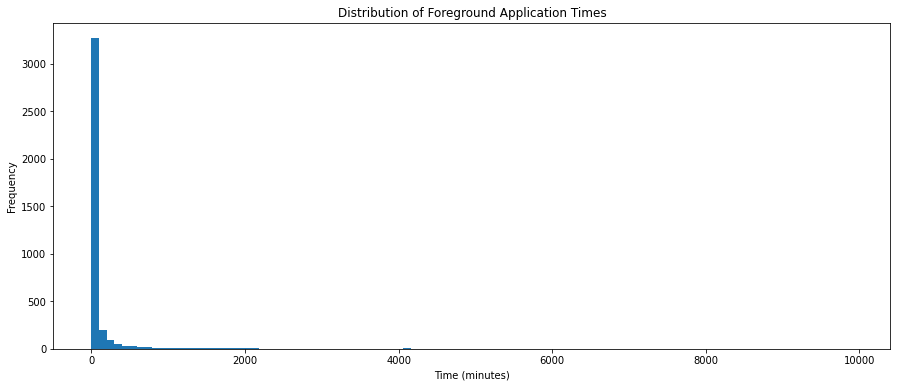

In [222]:
plt.figure(figsize=(15,6))
plt.hist(x=foreground_0['TIME_DELTA'], bins=100);
plt.title('Distribution of Foreground Application Times');
plt.xlabel('Time (minutes)');
plt.ylabel('Frequency');

In [223]:
foreground_0.head()

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA,TIME_DELTA
0,2021-11-20 21:30:30.578,3,cmd.exe,0,5.559
1,2021-11-20 21:30:36.137,3,explorer.exe,0,3.312
2,2021-11-20 21:30:39.449,3,chrome.exe,0,27.710
3,2021-11-20 21:31:07.159,3,explorer.exe,0,0.870
4,2021-11-20 21:31:08.029,3,chrome.exe,0,579.040


In [224]:
# foreground application time sum, mean, and std
stats = foreground_0.groupby(by=['VALUE']).agg(['sum', 'mean', 'std'])['TIME_DELTA']
stats

,sum,mean,std
VALUE,,,
anaconda3-2021.11-windows-x86_64.exe,85.453,21.363250,15.395167
applicationframehost.exe,11.746,5.873000,2.658721
chrome.exe,282060.179,282.060179,907.853941
cmd.exe,30192.934,128.480570,856.374343
db browser for sqlite.exe,13673.542,83.375256,669.455116
devenv.exe,24201.306,75.629081,265.748894
discord.exe,57119.642,167.506282,861.035207
easeofaccessdialog.exe,97.641,97.641000,NaN
explorer.exe,46462.659,64.531471,527.179555


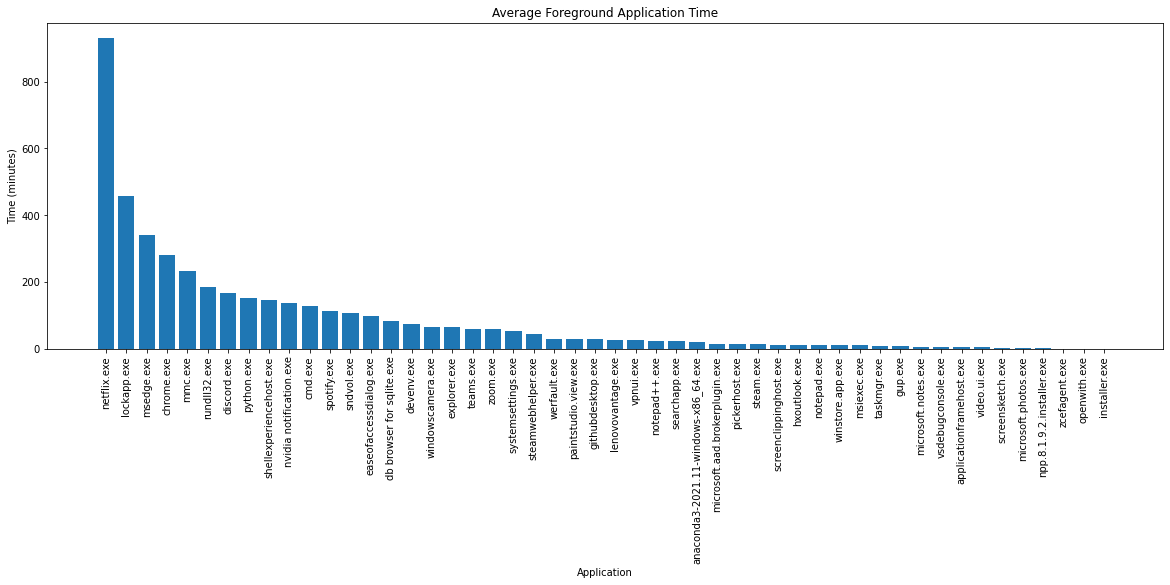

In [232]:
# average foreground application time
means = stats['mean'].sort_values(ascending=False)

plt.figure(figsize=(20, 6))
# removing outlier: "startmenuexperiencehost.exe"
plt.bar(x=means.index[1:], height=means.values[1:])
plt.title('Average Foreground Application Time');
plt.xlabel('Application');
plt.ylabel('Time (minutes)');
plt.xticks(rotation=90);

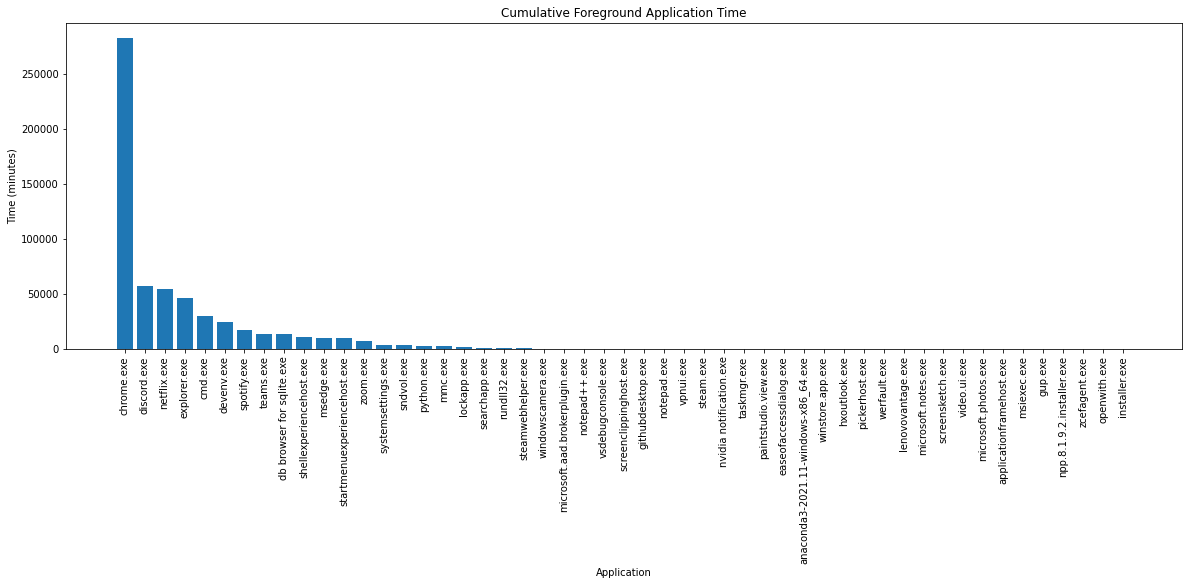

In [233]:
# cumulative foreground application time
sums = stats['sum'].sort_values(ascending=False)

plt.figure(figsize=(20, 6))
plt.bar(x=sums.index, height=sums.values)
plt.title('Cumulative Foreground Application Time');
plt.xlabel('Application');
plt.ylabel('Time (minutes)');
plt.xticks(rotation=90);